## Visualise image-specific class saliency with backpropagation

In [1]:
import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models

from flashtorch.utils import (apply_transforms,
                              denormalize,
                              format_for_plotting,
                              load_image,
                              normalize,
                              visualize)

from flashtorch.utils import ImageNetIndex

from flashtorch.saliency import Backprop

In [2]:
class ActivationMaximization(nn.Module):
    def __init__(self, model, target=24):
        super().__init__()
        
        self.model = model
        self.target = target
        
        self.activation = None
        self.gradients = None

    def _register_forward_hooks(self, layer_idx, filter_idx):
        def _record_activation(module, input_, output):
            self.activation = torch.mean(output[:,filter_idx,:,:])
            
        self.model[layer_idx].register_forward_hook(_record_activation)
        
    def _register_backward_hooks(self):
        def _record_gradients(module, grad_in, grad_out):
            if self.gradients.shape == grad_in[0].shape:
                self.gradients = grad_in[0]

        for _, module in self.model.named_modules():
            if isinstance(module, nn.modules.conv.Conv2d) and \
                    module.in_channels == 3:
                module.register_backward_hook(_record_gradients)
                break
    
    def forward_backprop(self, x, layer_idx, filter_idx, num_iter=20):
        self._register_forward_hooks(layer_idx, filter_idx)
        self._register_backward_hooks()
        
        self.gradients = torch.zeros(input_.shape)
                                     
        for i in range(num_iter):
            self.model(x)
            
            loss = self.activation
            loss.backward()
            
            self.gradients /= (torch.sqrt(torch.mean(torch.mul(self.gradients, self.gradients))) + 1e-5)

            l2 = torch.norm(self.gradients)
            x = x + self.gradients
        
        return x
    
    def forward_backprop_with_adam(self, x, layer_idx, filter_idx, num_iter=20):
        self._register_forward_hooks(layer_idx, filter_idx)
        self._register_backward_hooks()
        
        optimizer = optim.Adam([x], lr=0.1, weight_decay=1e-5)

        self.gradients = torch.zeros(input_.shape)
                                     
        for i in range(num_iter):
            optimizer.zero_grad()
            
            self.model(x)
            
            self.activation.backward()
            
            optimizer.step()
        
        return x

### 2. Load a pre-trained Model

In [3]:
model = models.vgg16(pretrained=True)
list(model.features.named_children())

[('0', Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('1', ReLU(inplace)),
 ('2', Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('3', ReLU(inplace)),
 ('4',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('5', Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('6', ReLU(inplace)),
 ('7', Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('8', ReLU(inplace)),
 ('9',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('10', Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('11', ReLU(inplace)),
 ('12', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('13', ReLU(inplace)),
 ('14', Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
 ('15', ReLU(inplace)),
 ('16',
  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
 ('17', Conv2d(256, 512, kernel_size=(3, 

(-0.5, 511.5, 511.5, -0.5)

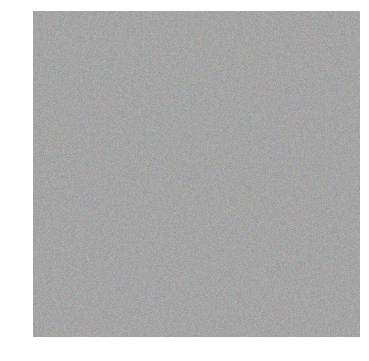

In [23]:
img_size = 512
input_noise = np.uint8(np.random.uniform(150, 180, (img_size, img_size, 3)))

plt.figure(figsize=(6, 6))
plt.imshow(torch.from_numpy(input_noise))
plt.axis('off')

In [60]:
active_max = ActivationMaximization(model.features)

input_ = apply_transforms(input_noise)

# image = load_image('./images/dalmatian_01.jpg')
# input_ = apply_transforms(image, 512) 

layer_idx = 24
filter_idx = 10

x = active_max.forward_backprop_with_adam(input_, layer_idx, filter_idx)

(-0.5, 223.5, 223.5, -0.5)

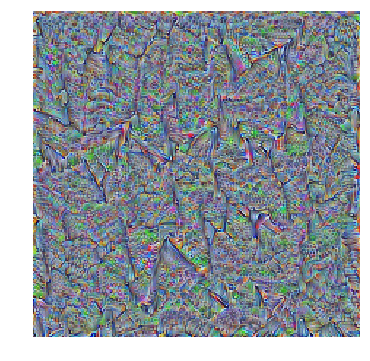

In [61]:
plt.figure(figsize=(6, 6))
plt.imshow(format_for_plotting(normalize(x)))
plt.axis('off')